In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [7]:
unique_adstext =ads.drop_duplicates(subset = ['atext'])

In [8]:
unique_adstext.nunique()

atitle     254397
atext      350006
adomain      5550
dtype: int64

In [9]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

254397

In [10]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'])

In [11]:
unique.nunique()

atitle     254397
atext      254396
adomain      5447
dtype: int64

In [12]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254397 entries, 0 to 772549
Data columns (total 3 columns):
atitle     254397 non-null object
atext      254396 non-null object
adomain    254397 non-null object
dtypes: object(3)
memory usage: 7.8+ MB


In [13]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [14]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [15]:
type(unique['atext'])

pandas.core.series.Series

In [16]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [17]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [18]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [21]:
unique['atext'][0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

# Train Test Split

In [22]:
X = unique['atext']
y = unique['atitle']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        text = series_copy[index]
        if lemmatize ==True:
            lemmas = m.lemmatize(text)

            lem_no_punct = [lemma for lemma in lemmas if lemma!= ' '
                           and lemma != '\n']
            output = lem_no_punct
        else:
            output = text.split()
        series_copy[index] =output
    return series_copy

In [25]:
X_train_processed = text_parser(X_train)

In [26]:
y_train_processed = text_parser(y_train)

In [27]:
merged_list = X_train_processed+y_train_processed

# Training Word2Vec

In [28]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4 ,  
    size=300,      
    hs=1           
)


In [29]:
vocab = model.wv.vocab.keys()
print(len(vocab))

24801


In [30]:
model.wv.vocab['компьютер'].count

510

In [31]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 800:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


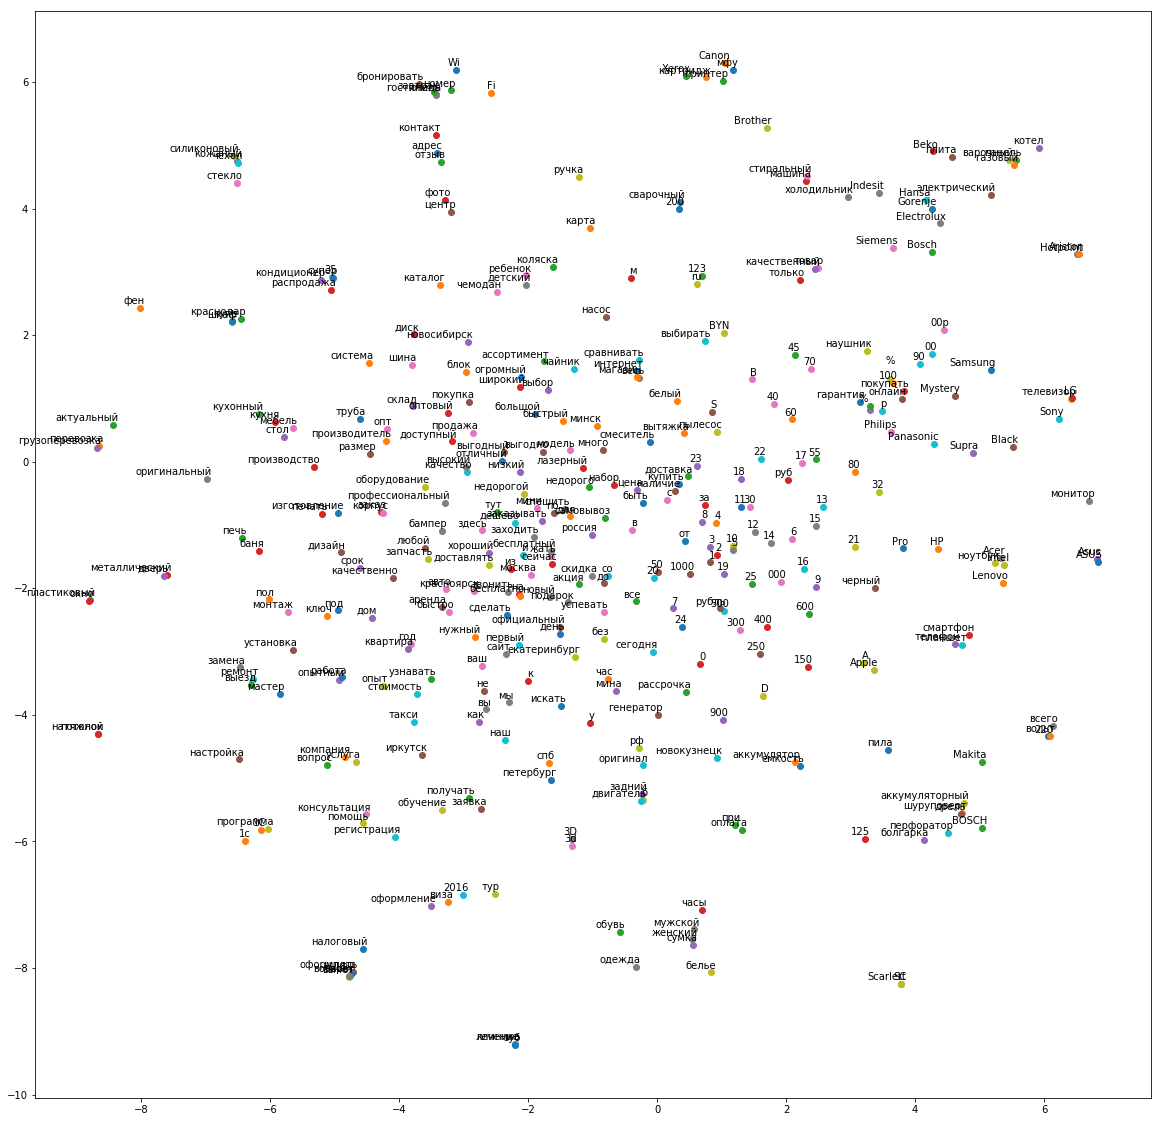

In [32]:
tsne_plot(model)

# Sample For Evaluation

In [33]:
indices = X_test.index

In [34]:
test_df = pd.DataFrame(X_test, index = indices)

In [35]:
test_df.head()

,atext
363796,Дышите естественно увлажненным и чистым воздух...
673780,Двери Океан Сравните цены всех интернет магазинов
20971,Купить Rexel Уничтожитель бумаги Rexel V120 bl...
485902,Цена всего 9390 руб Купить КАЛИБР СС 16 550
207235,Телевизор Supra STV LC24T440WL в интернет мага...


In [36]:
test_df['atitle'] = y_test

In [37]:
test_df.shape

(76320, 2)

In [38]:
# we can't fit all the examples in our memory

test_sample = test_df.sample(1000)

In [39]:
test_text_processed = text_parser(test_sample['atext'])

In [40]:
test_title_processed = text_parser(test_sample['atitle'])

In [41]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [42]:
ad_vectors = []
for ad_text in test_text_processed:
        vector = result_vector(ad_text)
        if vector is not None:
            ad_vectors.append(vector)
        else:
            ad_vectors.append('M')

In [43]:
title_vectors = []
for ad_title in test_title_processed:
    vector = result_vector(ad_title)
    if vector is not None:
        title_vectors.append(vector)
    else:
        title_vectors.append('M')

In [44]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        if each != 'M':
            sim_score = cosine_similarity(vector_one, each)
            cosines.extend(sim_score) 
        else:
            cosines.append('M')
    return cosines

In [45]:
def rank_checker(first_vector_set, other_vectors, smpl_df, number):
    cosines_results = cosine_calculator(first_vector_set[number], other_vectors)
    series = pd.Series(cosines_results, index =smpl_df.index)
    
    #cleaning the series for sorting, 'M' stands for missing, was added if no words in the text were found in w2v vocab
    cleaned = series[series != 'M']
    sorted_df = cleaned.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == smpl_df.index[number]:
            return rank

In [46]:
ranks = []
for row in range(len(test_sample)):
    rank = rank_checker(ad_vectors, title_vectors, test_sample, row)
    ranks.append(rank)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/ops.py:1122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


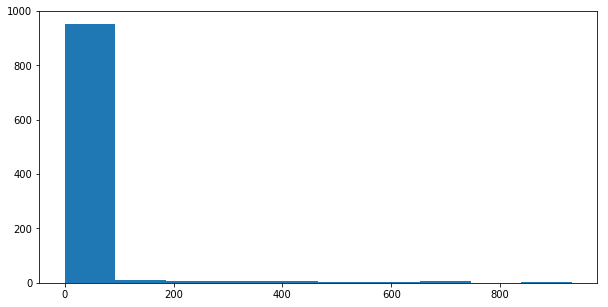

In [47]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [48]:
#average rank
sum([rank for rank in ranks if rank is not None])/ len([rank for rank in ranks if rank is not None])

20.42799597180262

In [49]:
small = []
for rank in ranks:
    if rank is not None and rank <=10:
        small.append(rank) 

In [50]:
# proportion ranked as 
len(small) / len([rank for rank in ranks if rank is not None])

0.9063444108761329

# Supervised Solution

In [51]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train_processed 
training_df['title vectors'] = y_train_processed 

In [52]:
X_test_processed= text_parser(X_test)

In [53]:
y_test_processed= text_parser(y_test)

In [54]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test_processed
test_df['title vectors'] = y_test_processed

In [55]:
training_df.shape

(178077, 2)

In [56]:
test_df.shape

(76320, 2)

In [57]:
# vectorization of the ads text
for row in range(len(training_df)):
    vector = result_vector(training_df.iloc[row, 0])
    if vector is not None:  
        training_df.iloc[row, 0] = vector[0]
    else:
        training_df.iloc[row, 0] = 'M'

In [58]:
# vectorization of the ads text
for row in range(len(test_df)):
    vector = result_vector(test_df.iloc[row, 0])
    if vector is not None:  
        test_df.iloc[row, 0] = vector[0]
    else:
        test_df.iloc[row, 0] = 'M'

In [59]:
# vectorization of the ads title
for row in range(len(training_df)):
    vector = result_vector(training_df.iloc[row, 1])
    if vector is not None:  
        training_df.iloc[row, 1] = vector[0]
    else:
        training_df.iloc[row, 1] = 'M'

In [60]:
# vectorization of the ads title
for row in range(len(test_df)):
    vector = result_vector(test_df.iloc[row, 1])
    if vector is not None:  
        test_df.iloc[row, 1] = vector[0]
    else:
        test_df.iloc[row, 1] = 'M'

In [61]:
training_df.head()

,text vectors,title vectors
538293,"[-0.1291679617175341, -0.007706508626888477, -...","[-0.11158272256689265, 0.030740431576979234, -..."
109045,"[-0.03865497684797547, -0.045398328862653436, ...","[0.06110259114557712, -0.017299616618409126, 0..."
270496,"[0.023836182835915688, 0.006411689405421077, -...","[0.042430772719051386, -0.009865370250896876, ..."
698055,"[-0.028714597962830945, -0.03402319844892566, ...","[-0.07255126039112422, 0.013485962036931129, -..."
170546,"[-0.028797989679766697, 0.05271424321296983, 0...","[0.0016802390553476547, 0.050263197783268286, ..."


In [62]:
len(test_df.iloc[0, 0])

300

In [63]:
len(training_df.iloc[0, 0])

300

In [64]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df= training_df[training_df['text vectors'] != 'M']
training_df = training_df[training_df['title vectors'] != 'M']

test_df= test_df[test_df['text vectors'] != 'M']
test_df = test_df[test_df['title vectors'] != 'M']

/usr/local/lib/python3.6/site-packages/pandas/core/ops.py:1122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


In [65]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

In [66]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    sim_score_one = first_half.apply(cosine_between_rows, axis = 1)
    sim_score_two = second_half.apply(cosine_between_rows, axis = 1)
    
    print('Mean cosine similarity score: first half', np.mean(sim_score_one))
    print('Mean cosine similarity score: second half', np.mean(sim_score_two))
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index = True)
    
    return concat_result

In [67]:
training_df_mixed = mixed_df_creator(training_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Mean cosine similarity score: first half [[0.75747993]]
Mean cosine similarity score: second half [[0.22966404]]


In [68]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[-0.1291679617175341, -0.007706508626888477, -...","[-0.11158272256689265, 0.030740431576979234, -...",1
1,"[-0.03865497684797547, -0.045398328862653436, ...","[0.06110259114557712, -0.017299616618409126, 0...",1
2,"[0.023836182835915688, 0.006411689405421077, -...","[0.042430772719051386, -0.009865370250896876, ...",1
3,"[-0.028714597962830945, -0.03402319844892566, ...","[-0.07255126039112422, 0.013485962036931129, -...",1
4,"[-0.028797989679766697, 0.05271424321296983, 0...","[0.0016802390553476547, 0.050263197783268286, ...",1


In [69]:
test_df_mixed = mixed_df_creator(test_df)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Mean cosine similarity score: first half [[0.74852766]]
Mean cosine similarity score: second half [[0.23326421]]


In [70]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [71]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[-0.1291679617175341, -0.007706508626888477, -...","[-0.11158272256689265, 0.030740431576979234, -...",1
1,"[-0.03865497684797547, -0.045398328862653436, ...","[0.06110259114557712, -0.017299616618409126, 0...",1
2,"[0.023836182835915688, 0.006411689405421077, -...","[0.042430772719051386, -0.009865370250896876, ...",1
3,"[-0.028714597962830945, -0.03402319844892566, ...","[-0.07255126039112422, 0.013485962036931129, -...",1
4,"[-0.028797989679766697, 0.05271424321296983, 0...","[0.0016802390553476547, 0.050263197783268286, ...",1


In [72]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [73]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [74]:
all_training_vectors = df_converter(training_df_mixed)

600


In [75]:
all_test_vectors = df_converter(test_df_mixed)

600


In [76]:
new_y_training = training_df_mixed['pair class']

In [77]:
new_y_test = test_df_mixed['pair class']

# Sample for Parameter Finetuning

In [78]:
sample_training_df = training_df_mixed.sample(10000)

In [79]:
sample_training_df.head()

,text vectors,title vectors,pair class
58775,"[-0.03258100530759171, -0.051615487014986874, ...","[-0.055692089077232936, -0.02844356793827989, ...",1
151831,"[-0.005772477883143632, -0.017039906929651998,...","[0.010385871158664725, -0.05153954080909224, -...",0
120316,"[-0.04931367694177498, -0.08545302662080938, -...","[-0.0647562968497056, -0.03096782372746753, -0...",0
89739,"[0.007763129056709354, 0.043217769246724755, -...","[-0.06417166603401879, -0.1261429148063698, -0...",0
150956,"[0.04467483252226835, 0.021653754453383516, -0...","[-0.04035021226830675, -0.03745363877692506, -...",0


In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 250)
X_train_pca = pca.fit_transform(all_training_vectors)

In [82]:
print(sum(pca.explained_variance_ratio_))

0.9365898789970937


In [83]:
X_test_pca = pca.transform(all_test_vectors)

# Finetuning Models

In [84]:
sample_training_arrays = df_converter(sample_training_df)

600


In [85]:
sample_y = sample_training_df['pair class']

In [86]:
pca_sample = PCA(n_components = 250)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [87]:
X_train_sample_pca.shape

(10000, 250)

In [88]:
print(sum(pca_sample.explained_variance_ratio_))

0.9394046299020152


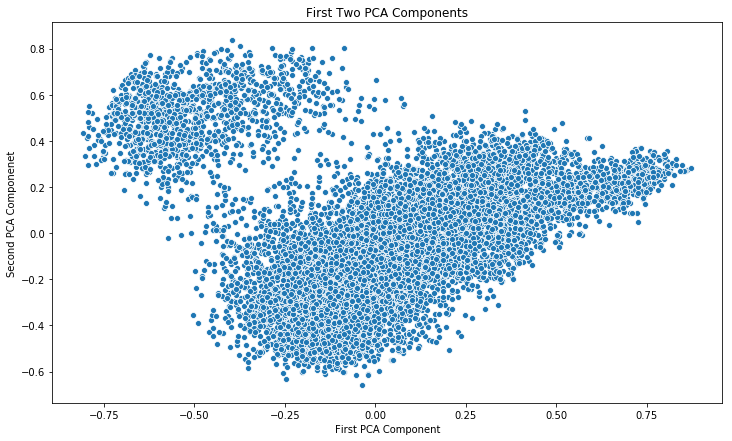

In [89]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

In [90]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'roc_auc', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [91]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5008819508300093
Best parameters {'C': 0.001, 'penalty': 'l2'}


In [92]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'roc_auc', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [93]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.9413876757267424
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [94]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200],
    'max_depth': [40, 50]}
]
rfc_one = RandomForestClassifier(n_jobs = -1)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'roc_auc', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200], 'max_depth': [40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [95]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.9431471754241236
Best parameters {'max_depth': 50, 'n_estimators': 1200}


In [96]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8],
    #'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'roc_auc', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [97]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9718156312826455
Best parameters {'max_depth': 8, 'n_estimators': 700}


In [98]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'roc_auc', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [99]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9729935537939527
Best parameters {'learning_rate': 0.1, 'n_estimators': 1000}


In [100]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 8, n_estimators=1000, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'roc_auc', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [101]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9729935537939527
Best parameters {'subsample': 1}


# Test Set

In [103]:
from sklearn.metrics import roc_auc_score
lr_test = LogisticRegression(C= 0.001, penalty= 'l2')

lr_test.fit(X_train_pca, new_y_training)

print(roc_auc_score(new_y_test, lr_test.predict_proba(X_test_pca)[:, 1]))

0.4952145610333967


In [104]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1200,
                            max_depth = 50)

rfc_test.fit(X_train_pca, new_y_training)

print(roc_auc_score(new_y_test, rfc_test.predict_proba(X_test_pca)[:, 1]))

0.9805293452791217


In [105]:
xgb_test = XGBClassifier(n_estimators = 1000,
                        max_depth = 8,
                        learning_rate= 0.1,
                        subsample = 1)

xgb_test.fit(X_train_pca, new_y_training)

print(roc_auc_score(new_y_test, xgb_test.predict_proba(X_test_pca)[:, 1]))

0.9934836118701228


In [ ]:
X_train_notlemmatized = text_parser(X_train, lemmatize=False)

In [ ]:
X_train_notlemmatized.iloc[1]

In [ ]:
X_practice_set= X_train.copy()

In [ ]:
X_practice_set.head()

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

def tokenization(texts):
    tokenizer.fit_on_texts(texts)
    total_words = len(tokenizer.word_index)+1
    
    input_sequences = []
    for ad in texts:
        token_list = tokenizer.texts_to_sequences([ad])[0]
        for index in range(1, len(token_list)):
            n_gram_sequence = token_list[:index+1]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences, total_words

In [ ]:
inp_sequences, total_words = tokenization(X_practice_set)

In [ ]:
len(input_sequences)

In [ ]:
total_words

In [ ]:
input_sequences[:5]

In [ ]:
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(entry) for entry in input_sequences])
    input_sequences_copy = np.array(pad_sequences(input_sequences, 
                                                  maxlen=max_sequence_len,
                                                  padding = 'pre'))
    
    predictors, label = input_sequences_copy[:, :-1], input_sequences_copy[:, -1]
    label = ku.to_categorical(label, num_classes = total_words)
    
    return predictors, label, max_sequence_len

In [ ]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

def create_model(max_sequence_length, total_words):
    input_len = max_sequence_len - 1
    
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length = input_len))
    
    model.add(LSTM(100))
    
    model.add(Dropout(0.25))
    
    model.add(Dense(total_words, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer = 'adam')
    
    return model

In [ ]:
model=create_model(max_sequence_len, total_words)
model.summary()

In [ ]:
model.fit(predictors, label, epochs=100, verbose=2)

In [ ]:
label.shape

In [ ]:
def generate_an_ad(ad_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([ad_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_sequence_len -1, padding = 'pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index==predicted:
                output_word = word
                break
        ad_text +=' '+output_word
                         
    return ad_text.title()

In [ ]:
generate_an_ad('Оформление ИП', 4, model, max_sequence_len)